In [28]:
import pandas as pd
import numpy as np
from convokit import Corpus, download
import matplotlib.pyplot as plt
import ssl
import random
# Disable SSL verification - because it is annoying
ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
awry_corpus = Corpus(filename=download("conversations-gone-awry-cmv-corpus")) #contains personal attacks
winning_corpus = Corpus(filename=download("winning-args-corpus"))

#convert the data into a dataframe
df_awry = awry_corpus.get_utterances_dataframe().reset_index()
df_winning = winning_corpus.get_utterances_dataframe().reset_index()

Dataset already exists at /Users/xehu/.convokit/downloads/conversations-gone-awry-cmv-corpus


# Corpus Information

## Conversations Gone Awry
- id: Reddit ID of the comment represented by the utterance
- speaker: the speaker who authored the utterance
- conversation_id: id of the first utterance in the conversation this utterance belongs to. Note that this differs from how ‘conversation_id’ is treated in ConvoKit’s general Reddit corpora: in those corpora a conversation is considered to start with a Reddit post utterance, whereas in this corpus a conversation is considered to start with a top-level reply to a post.
- reply_to: Reddit ID of the utterance to which this utterance replies to (None if the utterance represents a top-level comment, i.e., a reply to a post)
- timestamp: time of the utterance
- text: textual content of the utterance

## Winning Arguments
- id: index of the utterance (unique comment identification provided by Reddit)
- speaker: the unique id of the user who authored the utterance
- conversation_id: comment identifier of the original post in the thread that this comment was posted in
- reply_to: index of the utterance to which this utterance replies to (None if the utterance is not a reply)
- timestamp: utterance timestamp provided by Reddit API
- text: the full text (in string) of the comment
- success: an indicator taking the value of 1 if the comment was part of a successful argument thread (i.e. an argument thread that changed the OP’s mind), 0 if unsuccessful, and None if not part of either a successful or unsuccessful thread.
- pair_ids: every successful-unsuccessful argument pair originally compiled by the authors has a unique pair_id. However, it is important to note that not every argument is unique (i.e. a single negative argument within a conversation could have two opposing positive arguments, which necessitates two corresponding pair_ids. Therefore, pair_ids is a list).

Note: we should also add additional covariates, such as `meta.score`, provided they are shared across the datasets

Note: `p_4263` is the largest and final pair ID.

In [13]:
winning_conversation_threads = []

In [14]:
LARGEST_THREAD_ID = 4263

In [15]:
# Process the winning conversations into threads
for i in range(1, LARGEST_THREAD_ID): # these are the valid ID's we have

    # get threads
    pair_threads = df_winning[df_winning["meta.pair_ids"].apply(lambda x: "p_" + str(i) in x)]

    success_thread = pair_threads[pair_threads["meta.success"] == 0]
    unsuccessful_thread = pair_threads[pair_threads["meta.success"] == 1]

    # get OP (original post)
    OP_ID = pair_threads.iloc[0]["conversation_id"]
    op = df_winning[df_winning["id"]==OP_ID]
    op["reply_to"] = "ORIGINAL_POST"

    # OP+success
    success_conv = pd.concat([op, success_thread])
    unsuccess_conv = pd.concat([op, unsuccessful_thread])

    # CONV_ID: an ID that we assign to designate a conversation that we're "splitting up here"
    success_conv["CONV_ID"] = str(i) + "_A"
    unsuccess_conv["CONV_ID"] = str(i) + "_B"

    winning_conversation_threads.append(success_conv)
    winning_conversation_threads.append(unsuccess_conv)


/var/folders/gy/yd7v599s1qd49r7p_bgk88lr0000gn/T/ipykernel_24417/2619955845.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op["reply_to"] = "ORIGINAL_POST"
/var/folders/gy/yd7v599s1qd49r7p_bgk88lr0000gn/T/ipykernel_24417/2619955845.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op["reply_to"] = "ORIGINAL_POST"
/var/folders/gy/yd7v599s1qd49r7p_bgk88lr0000gn/T/ipykernel_24417/2619955845.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [16]:
# Here are our winning conversations, grouped into the relevant threads
df_winning_conversations = pd.concat(winning_conversation_threads, axis=0)

In [17]:
# Make `CONV_ID` the ID to use in both dataframes
df_awry.rename(columns={"conversation_id": "CONV_ID"}, inplace=True)

In [18]:
# select shared set of columns for both
shared_cols = ["CONV_ID", "text", "speaker", "id", "timestamp", "meta.score", "reply_to"]
df_winning_conversations = df_winning_conversations[shared_cols]
df_awry = df_awry[shared_cols]

In [20]:
#add conversation_length to the dfs
df_winning_conversations['conversation_length'] = df_winning_conversations.groupby('CONV_ID')['CONV_ID'].transform('count')
df_awry['conversation_length'] = df_awry.groupby('CONV_ID')['CONV_ID'].transform('count')

#### Output: `df_winning_conversations` and `df_awry`
At this point, we output the two datasets, which have a shared set of columns:
- `CONV_ID`: the conversation ID (unique identifier per conversation thread)
- `text`: the text of each message
- `speaker`: the identifier of the person saying the message
- `id`: a unique identifier for the message
- `timestamp`: the timestamp for the message
- `meta.score`: the score (upvotes-downvotes) of the message
- `reply_to`: the index of the utterance being replied to; is denoted as `ORIGINAL_POST` if this is OP.
- `conversation_length`: length of the conversation

In [21]:
df_awry.head()

,CONV_ID,text,speaker,id,timestamp,meta.score,reply_to,conversation_length
0,cue8y0b,"(Okay, I've seen this view come up a few times...",RustyRook,cue8y0b,1440446000,17,None,10
1,cue8y0b,It's not just black and white America though. ...,Canada_is_gay,cuec5fs,1440450798,4,cue8y0b,10
2,cue8y0b,Abstract reasoning is a skill that can be nurt...,aguafiestas,cuect48,1440451823,3,cuec5fs,10
3,cue8y0b,Can we agree that genes account for about 50% ...,ScholarlyVirtue,cuedf8c,1440452797,3,cuect48,10
4,cue8y0b,Twin studies studies suggest that about 80 per...,Perpetualjoke,cuedywn,1440453690,7,cuedf8c,10


In [22]:
awry_summary = df_awry.groupby("CONV_ID").size().reset_index(name="row_count")

print(str(len(set(df_awry["CONV_ID"]))) + " total conversations")
print("Mean number of message per conversation:")
print(awry_summary["row_count"].mean())
print("Stdev number of messages per conversation:")
print(awry_summary["row_count"].std())

6842 total conversations
Mean number of message per conversation:
6.279450453083894
Stdev number of messages per conversation:
3.2957714495988015


In [23]:
df_winning_conversations.head()

,CONV_ID,text,speaker,id,timestamp,meta.score,reply_to,conversation_length
0,1_A,I can't remember the topic that spurred this d...,seanyowens,t3_2ro9ux,None,None,ORIGINAL_POST,2
27,1_A,You're using natural to mean definition 8\n\n&...,Nepene,t1_cnhqcwz,1420698347,1,t3_2ro9ux,2
0,1_B,I can't remember the topic that spurred this d...,seanyowens,t3_2ro9ux,None,None,ORIGINAL_POST,4
1,1_B,"Look at the definition you provided, if we rem...",Account9726,t1_cnhplrm,1420697092,20,t3_2ro9ux,4
2,1_B,∆. Yours was the first comment I read to make...,seanyowens,t1_cnhrvq7,1420700886,2,t1_cnhplrm,4


In [24]:
# do this only after filtering out the OP's, as this creates a more fair comparison to Conversations Gone Awry
winning_summary = df_winning_conversations[df_winning_conversations["reply_to"] != "ORIGINAL_POST"].groupby("CONV_ID").size().reset_index(name="row_count")

print(str(len(set(df_winning_conversations["CONV_ID"]))) + " total conversations")
print("Mean number of message per conversation:")
print(winning_summary["row_count"].mean())
print("Stdev number of messages per conversation:")
print(winning_summary["row_count"].std())

8524 total conversations
Mean number of message per conversation:
2.4087282965743784
Stdev number of messages per conversation:
1.517854574025008


# Get a Random Sample of Conversations

In [31]:
"""
function: randomly_sample_conversations_ids

@param df: the conversation dataframe
@param n_conversations: the number of conversations to sample
"""
def randomly_sample_conversations_ids(df, n_conversations):
    conversation_ids = list(set(df["CONV_ID"]))
    return random.sample(conversation_ids, n_conversations)

In [37]:
random.seed(19104)
N_CONVS = 100 # get 100 conversations each

# Get sample of winning and awry conversations
winning_sample = df_winning_conversations[df_winning_conversations["CONV_ID"].isin(randomly_sample_conversations_ids(df_winning_conversations, N_CONVS))]
awry_sample = df_awry[df_awry["CONV_ID"].isin(randomly_sample_conversations_ids(df_awry, N_CONVS))]

### Save the Sampled Conversations

In [39]:
awry_sample.to_csv('./samples/awry_samples.csv')
winning_sample.to_csv('./samples/winning_samples.csv')

In [40]:
### Ensure Sampled Conversations are Reasonable --- using Priya's visualizer tool

#plot the sample metrics vs population metrics
def validate_samples(df_samples,df_popluation,metrics_to_plot,conv_id_col):

    #length of the sample df
    print('Length of the sample df ' + str(len(df_samples)))

    #length of the sample df
    print('Number of unique conversations ' + str(df_samples[conv_id_col].nunique()))

    #length of all the conversation in the sample df = length of the converasation in the population df
    merged_df = pd.merge(df_samples, df_popluation, on=conv_id_col, suffixes=('_df1', '_df2'), how='left')
    are_lengths_matching = merged_df['conversation_length_df1'].equals(merged_df['conversation_length_df2'])
    print(f"The conversation lengths for each conversation ID in the sample dataset {'MATCHES' if are_lengths_matching else 'DOES NOT match'} with the population dataset.")

    # Find common conversation_ids between df1 and df2
    common_ids = set(df_samples[conv_id_col]).intersection(df_popluation[conv_id_col])
    concatenated_text_df1 = df_samples[df_samples[conv_id_col].isin(common_ids)].groupby(conv_id_col)['text'].agg(' '.join)
    concatenated_text_df2 = df_popluation[df_popluation[conv_id_col].isin(common_ids)].groupby(conv_id_col)['text'].agg(' '.join)
    are_texts_matching = concatenated_text_df1.equals(concatenated_text_df2)
    print(f"The concatenated text for each common conversation ID in the sample dataset {'MATCHES' if are_texts_matching else 'DOES NOT match'} with the population dataset.")

    # Iterate over each metric and plot the distribution
    for metric in metrics_to_plot:
        plt.figure(figsize=(8, 6))
        
        # Plot sample df
        df_samples[metric].plot(kind='kde',linestyle='solid', label=f'Sample', legend=True, color='blue')
        
        # Plot population df
        df_popluation[metric].plot(kind='kde', linestyle='solid', label=f'Population', legend=True, color='orange')
        
        plt.title(f'Distribution of {metric} across all conversation_ids')
        plt.xlabel(metric)
        plt.ylabel('Kernel Density')
        plt.show()

Length of the sample df 589
Number of unique conversations 100
The conversation lengths for each conversation ID in the sample dataset MATCHES with the population dataset.
The concatenated text for each common conversation ID in the sample dataset MATCHES with the population dataset.


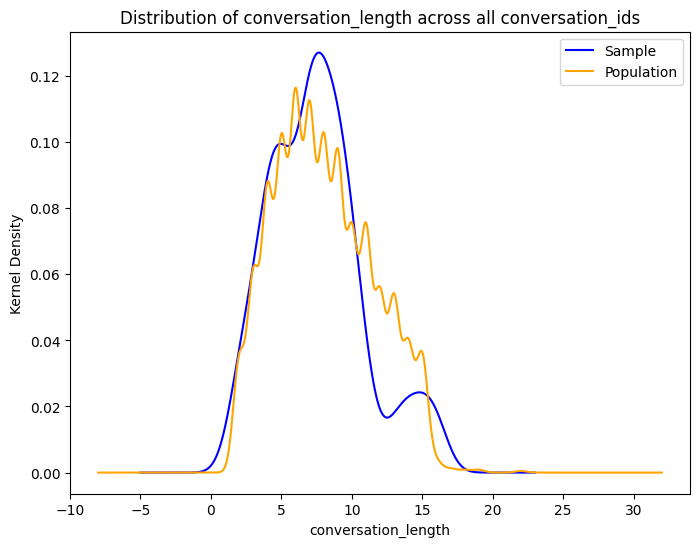

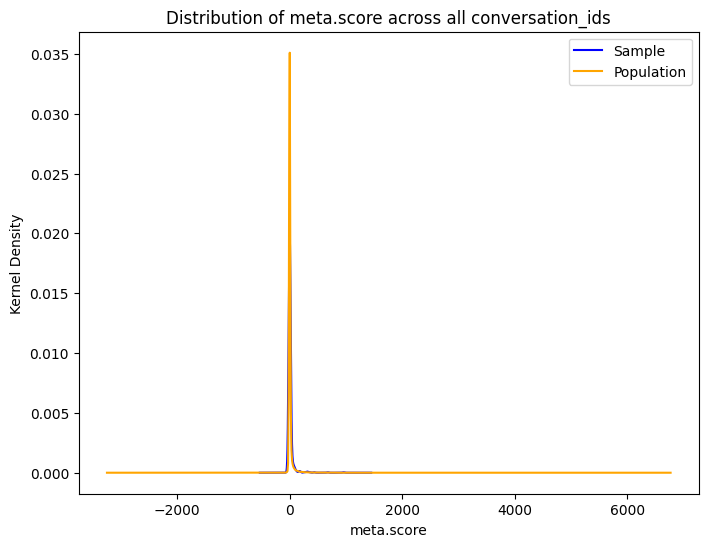

In [41]:
validate_samples(awry_sample,df_awry,["conversation_length", "meta.score"], "CONV_ID")

Length of the sample df 338
Number of unique conversations 100
The conversation lengths for each conversation ID in the sample dataset MATCHES with the population dataset.
The concatenated text for each common conversation ID in the sample dataset MATCHES with the population dataset.


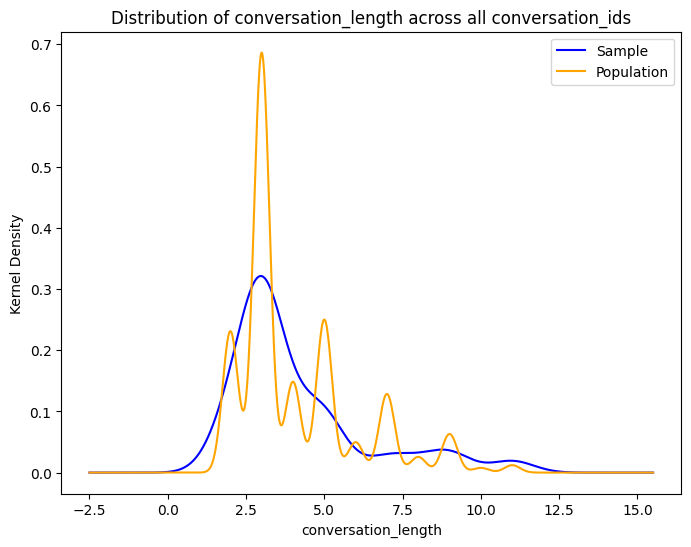

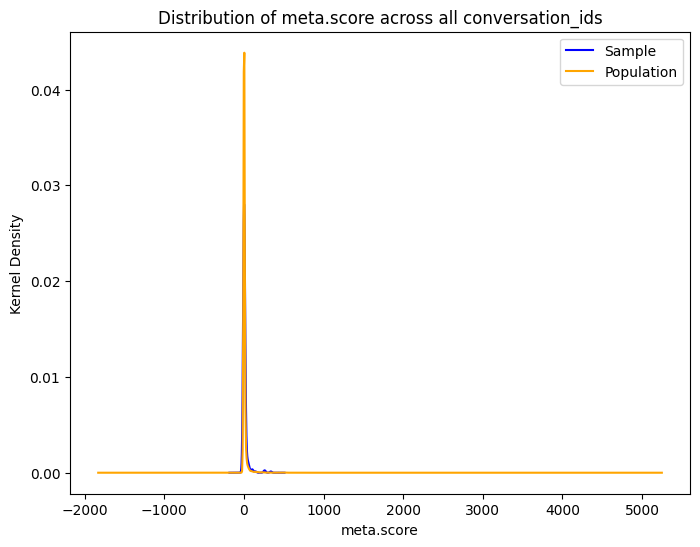

In [42]:
validate_samples(winning_sample,df_winning_conversations,["conversation_length", "meta.score"], "CONV_ID")